In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import nltk
import datetime
from datetime import datetime,date
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop,SGD
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Dropout, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [2]:
# Importing the data about NYSE:SPY for the same period that we have news data about
snp = yf.download("SPY", start = '2009-02-14', end = '2020-06-11')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
snp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2849 entries, 2009-02-17 to 2020-06-10
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, SPY)   2849 non-null   float64
 1   (High, SPY)    2849 non-null   float64
 2   (Low, SPY)     2849 non-null   float64
 3   (Open, SPY)    2849 non-null   float64
 4   (Volume, SPY)  2849 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 133.5 KB


In [4]:
# Removing the 'Ticker' column level leaving only the 'Price' level
# The 'Ticker' level has no valuable information because all the information in this DF is about the same ticker
snp.columns = snp.columns.get_level_values(0)

In [5]:
snp.head(5)

Price,Close,High,Low,Open,Volume
Date,,,,,
2009-02-17,58.597363,61.363760,58.560376,59.292662,478910100
2009-02-18,58.456825,59.129936,57.902066,59.018983,362964800
2009-02-19,57.828102,59.285271,57.709751,59.055966,316867500
2009-02-20,57.265953,57.946456,56.045481,56.755578,477176600
2009-02-23,55.217056,57.894692,55.172672,57.894692,379641400


In [6]:
# This is a CSV with around 1.4 million financial news articles from Feb 2009 to June 2020
news = pd.read_csv('analyst_ratings_processed.csv')

In [7]:
news

,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A
...,...,...,...,...
1400464,1413844.0,Top Narrow Based Indexes For August 29,2011-08-29 10:41:00-04:00,ZX
1400465,1413845.0,Recap: Wednesday's Top Percentage Gainers and ...,2011-06-22 16:44:00-04:00,ZX
1400466,1413846.0,UPDATE: Oppenheimer Color on China Zenix Auto ...,2011-06-21 08:26:00-04:00,ZX
1400467,1413847.0,Oppenheimer Initiates China Zenix At Outperfor...,2011-06-21 05:59:00-04:00,ZX


In [8]:
news.drop(news.columns[0], axis=1,inplace=True)

In [9]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400469 entries, 0 to 1400468
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   title   1400469 non-null  object
 1   date    1399180 non-null  object
 2   stock   1397891 non-null  object
dtypes: object(3)
memory usage: 32.1+ MB


In [10]:
news.head(5)

,title,date,stock
0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A


In [11]:
# There aren't that many NaNs so we decided to just drop all the rows with any NaNs
news.dropna(how='any', axis=0, inplace=True)

In [12]:
# Change the "data" column into DateTime datatype
news["date"] = pd.to_datetime(news["date"], utc=True)

In [13]:
format_string = "%Y-%m-%d"
date_list = []

for date in news['date']:
  date_list.append( datetime.strftime(date,format_string))

news['date'] = date_list
news["date"] = pd.to_datetime(news["date"])
news.head()

,title,date,stock
0,Stocks That Hit 52-Week Highs On Friday,2020-06-05,A
1,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03,A
2,71 Biggest Movers From Friday,2020-05-26,A
3,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22,A
4,B of A Securities Maintains Neutral on Agilent...,2020-05-22,A


In [14]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1397891 entries, 0 to 1400468
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   title   1397891 non-null  object        
 1   date    1397891 non-null  datetime64[ns]
 2   stock   1397891 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 42.7+ MB


In [15]:
# Sort the data by the date the news articles were published. Older articles first
news.sort_values(by='date', inplace=True)
news

,title,date,stock
871908,How Treasuries and ETFs Work,2009-02-14,NAV
514182,Update on the Luxury Sector: 2nd Quarter 2009,2009-04-27,FT
1383168,Update on the Luxury Sector: 2nd Quarter 2009,2009-04-27,Y
1828,Going Against the Herd,2009-04-29,A
64705,Charles Sizemore Radio Interview Saturday Morning,2009-05-22,AM
...,...,...,...
1251189,Tyson Says It's 'Fully Cooperating' Amid Price...,2020-06-11,TSN
1251188,Why Tyson Foods Stock Is Trading Lower Today,2020-06-11,TSN
548826,Shares of several automaker & auto component c...,2020-06-11,GM
1296766,Afternoon Market Stats in 5 Minutes,2020-06-11,VGK


In [16]:
# We have 6192 different stocks

news['stock'].nunique()

6192

In [17]:
news['year'] = news['date'].dt.year

# Group by year and stock and count occurrences
popularity = news.groupby(['year', 'stock']).size().reset_index(name='count')

# For each year, find the stock with the highest count
most_popular = popularity.loc[popularity.groupby('year')['count'].idxmax()]

most_popular

,year,stock,count
0,2009,A,949
4143,2010,MS,608
8535,2011,QQQ,1170
10911,2012,EWP,785
14292,2013,BBRY,886
19623,2014,EBAY,670
24917,2015,GPRO,777
32586,2016,YHOO,703
35227,2017,NFLX,746
39523,2018,NFLX,780


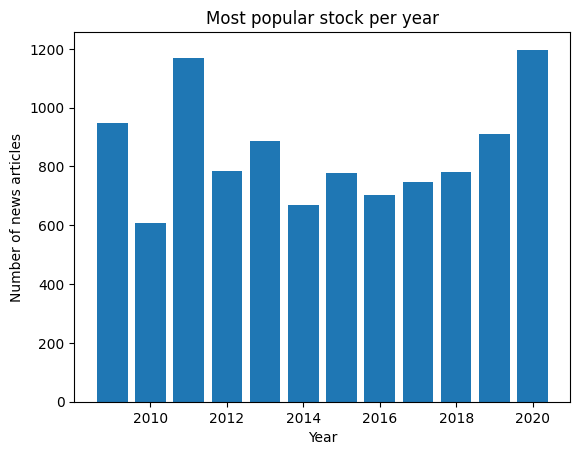

In [18]:
plt.bar(most_popular['year'], most_popular['count'])
plt.xlabel('Year')
plt.ylabel('Number of news articles')
plt.title('Most popular stock per year')
plt.show()

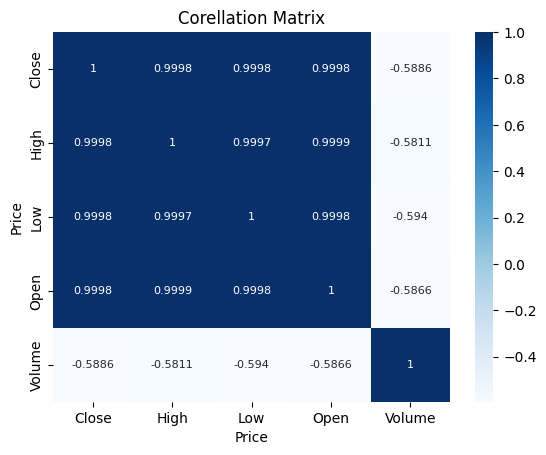

In [19]:
sns.heatmap(snp.select_dtypes(['number']).corr(),
            annot= True, fmt='.4g', annot_kws={"size": 8}, cmap= 'Blues')
plt.title("Corellation Matrix")
plt.show()

EDA SNP DataFrame

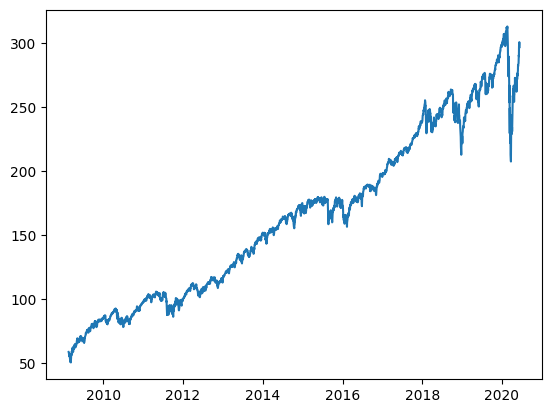

In [20]:
# See the stock price
plt.plot(snp['Close'])
plt.show()

In [21]:
snp['Close'].values.mean()

np.float64(163.94893816288163)

In [22]:
news

,title,date,stock,year
871908,How Treasuries and ETFs Work,2009-02-14,NAV,2009
514182,Update on the Luxury Sector: 2nd Quarter 2009,2009-04-27,FT,2009
1383168,Update on the Luxury Sector: 2nd Quarter 2009,2009-04-27,Y,2009
1828,Going Against the Herd,2009-04-29,A,2009
64705,Charles Sizemore Radio Interview Saturday Morning,2009-05-22,AM,2009
...,...,...,...,...
1251189,Tyson Says It's 'Fully Cooperating' Amid Price...,2020-06-11,TSN,2020
1251188,Why Tyson Foods Stock Is Trading Lower Today,2020-06-11,TSN,2020
548826,Shares of several automaker & auto component c...,2020-06-11,GM,2020
1296766,Afternoon Market Stats in 5 Minutes,2020-06-11,VGK,2020


EDA news DataFrame

In [23]:
# Removing any stopwords and doing lemmatization on the news titles ('title') text

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    words = word_tokenize(str(text).lower())
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    return " ".join(words)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [24]:
# Create a new column in the 'news' DataFrame, and add there all the article titles after they were cleaned and preprocessed
news['clean_titles'] = news["title"].fillna("").apply(clean_text)
news['clean_titles']

,clean_titles
871908,treasury etf work
514182,update luxury sector 2nd quarter 2009
1383168,update luxury sector 2nd quarter 2009
1828,going herd
64705,charles sizemore radio interview saturday morning
...,...
1251189,tyson say cooperating amid price fixing probe wsj
1251188,tyson food stock trading lower today
548826,share several automaker auto component company...
1296766,afternoon market stats 5 minute


In [25]:
# Create a tokenizer and fit it to the cleaned titles
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(news['clean_titles'].tolist())
word_index = tokenizer.word_index

In [26]:
# Show all the tokenized words
print(f"The tokenizer has {len(word_index)} words!")
word_list = dict(list(word_index.items())[:50])
word_list

The tokenizer has 97558 words!


{'<OOV>': 1,
 'stock': 2,
 'v': 3,
 'eps': 4,
 'share': 5,
 'report': 6,
 'est': 7,
 'market': 8,
 'update': 9,
 'earnings': 10,
 'sale': 11,
 'top': 12,
 'benzinga': 13,
 'price': 14,
 'pt': 15,
 'buy': 16,
 'lower': 17,
 'announces': 18,
 'company': 19,
 'downgrade': 20,
 'trading': 21,
 'raise': 22,
 'upgrade': 23,
 'target': 24,
 'maintains': 25,
 'etf': 26,
 'estimate': 27,
 'higher': 28,
 'new': 29,
 'session': 30,
 'say': 31,
 'moving': 32,
 'see': 33,
 'q4': 34,
 'revenue': 35,
 'bank': 36,
 'q1': 37,
 'q2': 38,
 'q3': 39,
 'high': 40,
 'energy': 41,
 'initiate': 42,
 'u': 43,
 'neutral': 44,
 'industry': 45,
 'scheduled': 46,
 'low': 47,
 'coverage': 48,
 'beat': 49,
 'morgan': 50}

Label Column

In [27]:
# Create a new column 'Change' and show if the stock price is going up(1), down(-1), or staying neutral(0)
# If the change is +-1.5 then it is considered neutral(0)

neutral_threshold=1.5
snp['Change'] = snp['Close'].shift(-5) - snp['Close']
snp.loc[(snp['Change'] > -neutral_threshold) & (snp['Change'] < neutral_threshold), 'label'] = 0
snp.loc[snp['Change'] >= neutral_threshold, 'label'] = 1
snp.loc[snp['Change'] <= -neutral_threshold, 'label'] = -1

In [28]:
snp.dropna(inplace=True)

In [29]:
snp.head(8)

Price,Close,High,Low,Open,Volume,Change,label
Date,,,,,,,
2009-02-17,58.597363,61.363760,58.560376,59.292662,478910100,-1.287006,0.0
2009-02-18,58.456825,59.129936,57.902066,59.018983,362964800,-1.597679,-1.0
2009-02-19,57.828102,59.285271,57.709751,59.055966,316867500,-1.893566,-1.0
2009-02-20,57.265953,57.946456,56.045481,56.755578,477176600,-2.581482,-1.0
2009-02-23,55.217056,57.894692,55.172672,57.894692,379641400,-2.995708,-1.0
2009-02-24,57.310356,57.658001,55.254043,55.690457,426260900,-5.481030,-1.0
2009-02-25,56.859146,58.005646,55.941940,57.058857,461985800,-3.801956,-1.0
2009-02-26,55.934536,58.930233,55.867962,57.561828,363353900,-5.044621,-1.0


In [30]:
# Drop the first row becouse the 'Change' there is NaN
snp.drop(snp.index[0], axis=0, inplace=True)

In [31]:
year_2009_2010 = snp[0:253]
year_2019_2020 = snp[2594:]

In [32]:
print(round(year_2009_2010['Volume'].mean()))

229884580


In [33]:
print(round(year_2019_2020['Volume'].mean()))

94335302


In [34]:
print(year_2009_2010['Change'].mean())

0.5252475964693213


In [35]:
print(year_2019_2020['Change'].mean())

0.6628914338996611


In [36]:
print(year_2009_2010['Close'].mean())

73.60390672947578


In [37]:
print(year_2019_2020['Close'].mean())

275.5114839852574


In [38]:
# See how many up/down/neutral days we have
snp['label'].value_counts()

,count
label,
0.0,1259
1.0,1003
-1.0,581


In [39]:
snp

Price,Close,High,Low,Open,Volume,Change,label
Date,,,,,,,
2009-02-18,58.456825,59.129936,57.902066,59.018983,362964800,-1.597679,-1.0
2009-02-19,57.828102,59.285271,57.709751,59.055966,316867500,-1.893566,-1.0
2009-02-20,57.265953,57.946456,56.045481,56.755578,477176600,-2.581482,-1.0
2009-02-23,55.217056,57.894692,55.172672,57.894692,379641400,-2.995708,-1.0
2009-02-24,57.310356,57.658001,55.254043,55.690457,426260900,-5.481030,-1.0
...,...,...,...,...,...,...,...
2020-05-28,281.695251,285.293493,281.016502,283.257274,90405200,7.800781,1.0
2020-05-29,282.950409,283.545453,278.440974,281.221005,119090800,13.965302,1.0
2020-06-01,284.094025,284.707682,281.778884,282.299558,55758300,16.410645,1.0


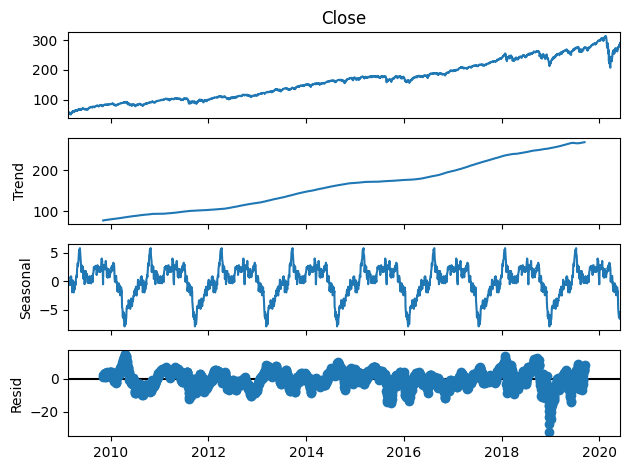

In [40]:
#עונה ומגמה בעזרת seasonal_decompose
result = seasonal_decompose(snp['Close'],
                            model='additive',
                            period=365)
result.plot()
plt.show()

## Classical ML models


In [41]:
snp['Date']= snp.index

In [42]:
snp['Index'] = range(0, len(snp))
snp.set_index(snp['Index'], inplace=True)
snp.drop('Index', axis=1,inplace=True)

In [43]:
snp.head(3)

Price,Close,High,Low,Open,Volume,Change,label,Date
Index,,,,,,,,
0,58.456825,59.129936,57.902066,59.018983,362964800,-1.597679,-1.0,2009-02-18
1,57.828102,59.285271,57.709751,59.055966,316867500,-1.893566,-1.0,2009-02-19
2,57.265953,57.946456,56.045481,56.755578,477176600,-2.581482,-1.0,2009-02-20


In [44]:
# Create the features and the targets for the models
# We droped the 'Date', 'Change' and 'label' becouse, data can't be changed in to a number to train with; change will give a very big hit (data leakage) for the label.
X = snp.drop(snp[['Date','Change','label']], axis=1)
y = snp['label']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
scaler_normal_models = StandardScaler()
X_train_scaled = scaler_normal_models.fit_transform(X_train)
X_test_scaled = scaler_normal_models.transform(X_test)

In [47]:
X_train_scaled

array([[-0.92042125, -0.91064178, -0.91628337, -0.90430389,  0.57674879],
       [ 1.40266763,  1.41191209,  1.29790198,  1.31591308,  0.20718838],
       [ 1.02221639,  1.01035866,  1.03932357,  1.02570285, -1.08472977],
       ...,
       [-0.40749767, -0.40512598, -0.39508708, -0.39702561, -0.67133203],
       [-0.14311541, -0.15436452, -0.15485875, -0.16152547, -0.42867153],
       [-0.85022235, -0.85569501, -0.8616842 , -0.85429889,  0.02999755]])

In [48]:
# Useing KNN
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train_scaled, y_train)
y_train_pred = knn.predict(X_train_scaled)
y_test_pred = knn.predict(X_test_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'train accuracy: {train_accuracy}')
print(f'test accuracy: {test_accuracy}')
print(f'delta: {train_accuracy-test_accuracy}')

# We got very poor results :(

train accuracy: 0.5778364116094987
test accuracy: 0.5166959578207382
delta: 0.06114045378876054


In [49]:
# Using Random Forset
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=40,
                            min_samples_split=4,
                            max_samples=200,
                            random_state=42)
rf.fit(X_train_scaled, y_train)
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'train accuracy: {train_accuracy}')
print(f'test accuracy: {test_accuracy}')
print(f'delta: {train_accuracy-test_accuracy}')

# We got very poor results :(

train accuracy: 0.6029023746701847
test accuracy: 0.5413005272407733
delta: 0.06160184742941144


In [50]:
# Using Decision Tree classifier
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'train accuracy: {train_accuracy}')
print(f'test accuracy: {test_accuracy}')
print(f'delta: {train_accuracy-test_accuracy}')

# We can see that using Decision Trees, the model is VERY overfitted

train accuracy: 1.0
test accuracy: 0.4358523725834798
delta: 0.5641476274165202


In [51]:
# Using LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'train accuracy: {train_accuracy}')
print(f'test accuracy: {test_accuracy}')
print(f'delta: {train_accuracy-test_accuracy}')

# We got very poor results :(

train accuracy: 0.5127528583992964
test accuracy: 0.5377855887521968
delta: -0.025032730352900434


## Time Series model

In [52]:
#נורמליזציה
scaler = MinMaxScaler(feature_range=(-1,1))
snp['Close_scaled'] = scaler.fit_transform(snp[['Close']])

In [53]:
#חלונות
def create_sequences (series, window_size):
  X,y =[],[]
  for i in range(len(series)-window_size):
    X.append(series[i:window_size +i])
    y.append(series[window_size +i])
  return np.array(X), np.array(y)

In [54]:
window_size = 740 # Every windows is a 2 year period
X, y = create_sequences(snp['Close_scaled'].values, window_size)

In [55]:
#train test split : testing the future
split_time = int(len(X)*0.8)
X_train, X_valid = X[:split_time], X[split_time:]
y_train, y_valid = y[:split_time], y[split_time:]

In [56]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid = X_valid.reshape((X_valid.shape[0],X_valid.shape[1], 1))

In [57]:
model = Sequential([
    Bidirectional(LSTM(40, return_sequences=True)),
    Bidirectional(LSTM(40)),
    Dense(1)
    ])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Reduce learning rate if validation loss stagnates
    factor=0.5,  # Reduce learning rate by half
    patience=5,  # Wait 2 epochs before reducing
    min_lr=1e-6,  # Minimum learning rate allowed
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='stock_price_prediction.keras',  # Save model to this file
    monitor='val_loss',  # Track validation loss
    save_best_only=True,  # Save only the best version of the model
    mode='min',  # "min" since we want to minimize the loss
    verbose=1  # Print a message when saving the model
)

early_stoping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto',
    restore_best_weights=True,
    start_from_epoch=5
)

model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=32,
    callbacks = [reduce_lr, checkpoint, early_stoping]
)

y_pred = model.predict(X_valid)

# מחזירים את הנתונים לסקאלה המקורית
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_valid = scaler.inverse_transform(y_valid.reshape(-1, 1))

# יצירת ציר זמן
time_valid = snp['Date'][split_time + window_size:]

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0272
Epoch 1: val_loss improved from inf to 0.00937, saving model to stock_price_prediction.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.0269 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 7.4167e-04
Epoch 2: val_loss improved from 0.00937 to 0.00656, saving model to stock_price_prediction.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 7.3967e-04 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 5.0907e-04
Epoch 3: val_loss improved from 0.00656 to 0.00546, saving model to stock_price_prediction.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 5.0846e-04 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 4.4922e-04
Epoch 4: val_loss improved from 0.00546 to 0.00430, saving model to stock_price_prediction.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 98

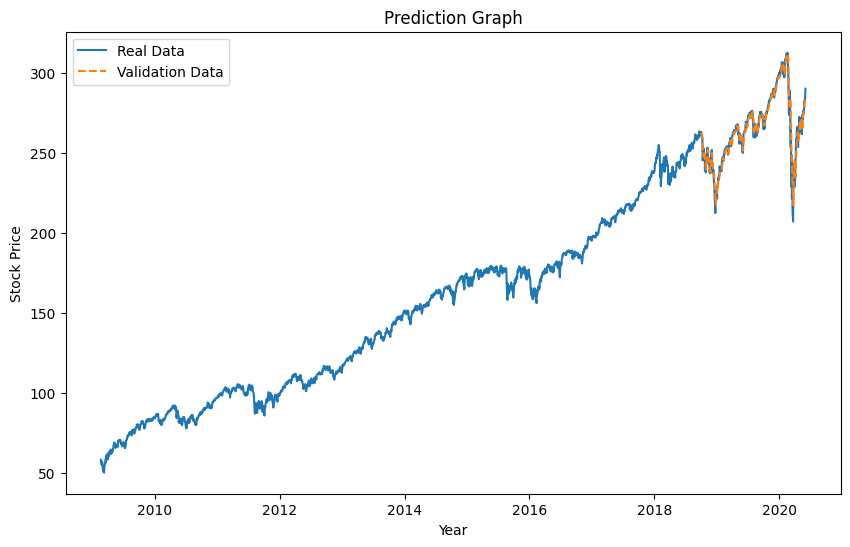

In [58]:
plt.figure(figsize=(10,6))
plt.plot(snp['Date'],
         scaler.inverse_transform(snp['Close_scaled'].values.reshape(-1, 1)),
         label="Real Data")
plt.plot(time_valid, y_pred, label="Validation Data", linestyle="dashed")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Stock Price")
plt.title("Prediction Graph")
plt.show()

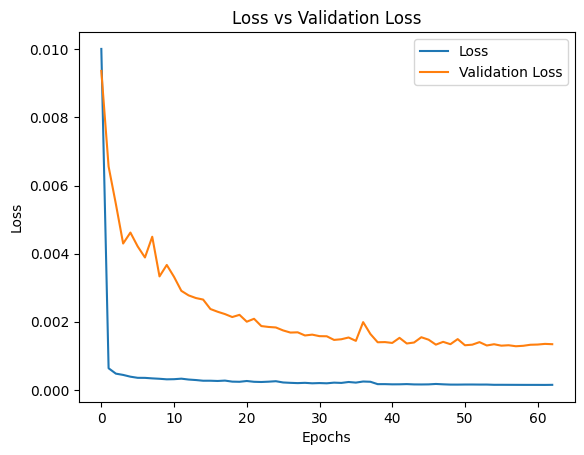

In [59]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Sentiment

In [60]:
news.head(3)

,title,date,stock,year,clean_titles
871908,How Treasuries and ETFs Work,2009-02-14,NAV,2009,treasury etf work
514182,Update on the Luxury Sector: 2nd Quarter 2009,2009-04-27,FT,2009,update luxury sector 2nd quarter 2009
1383168,Update on the Luxury Sector: 2nd Quarter 2009,2009-04-27,Y,2009,update luxury sector 2nd quarter 2009


In [61]:
train_sequences = tokenizer.texts_to_sequences(news['clean_titles'])
train_padded = pad_sequences(train_sequences, padding = 'pre')

In [62]:
model = Sequential([
    Embedding(input_dim =len(word_index)+1,
              output_dim =10),
    SimpleRNN(16),
    #NN
    Dense(32, activation ='relu'),
    Dropout(0.3),
    Dense(1,activation='sigmoid')])

In [63]:
sentiment = model.predict(train_padded)

43685/43685 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step


In [64]:
sentiment

array([[0.5085069 ],
       [0.49960566],
       [0.49960566],
       ...,
       [0.5354994 ],
       [0.5054392 ],
       [0.50511295]], dtype=float32)

In [65]:
news['sentiment'] = sentiment

In [66]:
sentiment_per_day_mean = news.groupby('date', as_index=False)['sentiment'].mean()

In [67]:
sentiment_per_day_sum = news.groupby('date', as_index=False)['sentiment'].sum()

In [68]:
sentiment_per_day_mean

,date,sentiment
0,2009-02-14,0.508507
1,2009-04-27,0.499606
2,2009-04-29,0.498884
3,2009-05-22,0.508033
4,2009-05-27,0.496923
...,...,...
3954,2020-06-07,0.508108
3955,2020-06-08,0.502257
3956,2020-06-09,0.502458
3957,2020-06-10,0.506547


In [69]:
snp = pd.merge(snp, sentiment_per_day_mean, left_on='Date', right_on='date', how='left')

In [70]:
snp = pd.merge(snp, sentiment_per_day_sum, left_on='Date', right_on='date', how='left')

In [71]:
snp.dropna(inplace=True)
snp.drop(['date_x','date_y'],axis=1,inplace=True)
snp.rename(columns={'sentiment_x':'sentiment_mean'},inplace=True)
snp.rename(columns={'sentiment_y':'sentiment_sum'},inplace=True)

In [72]:
snp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2755 entries, 47 to 2842
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Close           2755 non-null   float64       
 1   High            2755 non-null   float64       
 2   Low             2755 non-null   float64       
 3   Open            2755 non-null   float64       
 4   Volume          2755 non-null   int64         
 5   Change          2755 non-null   float64       
 6   label           2755 non-null   float64       
 7   Date            2755 non-null   datetime64[ns]
 8   Close_scaled    2755 non-null   float64       
 9   sentiment_mean  2755 non-null   float32       
 10  sentiment_sum   2755 non-null   float32       
dtypes: datetime64[ns](1), float32(2), float64(7), int64(1)
memory usage: 236.8 KB


In [73]:
snp

,Close,High,Low,Open,Volume,Change,label,Date,Close_scaled,sentiment_mean,sentiment_sum
47,63.948521,64.820144,63.725032,63.829328,289581600,3.754658,1.0,2009-04-27,-0.896563,0.499606,0.999211
49,65.103218,65.825843,64.291200,64.455089,311505700,3.538612,1.0,2009-04-29,-0.887761,0.498884,0.498884
66,66.317528,67.047604,66.064240,66.645318,166811900,4.283600,1.0,2009-05-22,-0.878504,0.508033,0.508033
68,66.801788,68.351335,66.697492,68.120395,246015800,2.964973,1.0,2009-05-27,-0.874813,0.496923,1.490768
69,67.732986,68.045874,66.377135,67.390299,289095000,2.689362,1.0,2009-05-28,-0.867714,0.514097,1.542292
...,...,...,...,...,...,...,...,...,...,...,...
2838,281.695251,285.293493,281.016502,283.257274,90405200,7.800781,1.0,2020-05-28,0.763326,0.504379,389.885071
2839,282.950409,283.545453,278.440974,281.221005,119090800,13.965302,1.0,2020-05-29,0.772894,0.505277,267.796844
2840,284.094025,284.707682,281.778884,282.299558,55758300,16.410645,1.0,2020-06-01,0.781612,0.505785,347.979919
2841,286.446381,286.492887,283.675657,285.023819,74267200,11.817505,1.0,2020-06-02,0.799544,0.504525,276.984375


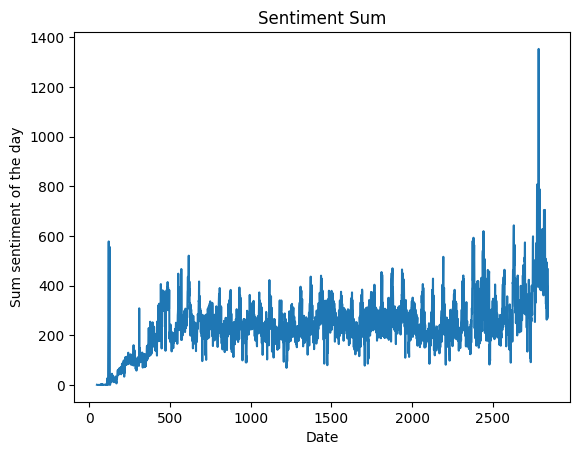

In [74]:
# The graph of the sum of all the sentiments of the news articles in given a day
plt.plot(snp['sentiment_sum'])
plt.title("Sentiment Sum")
plt.xlabel("Date")
plt.ylabel("Sum sentiment of the day")
plt.show()

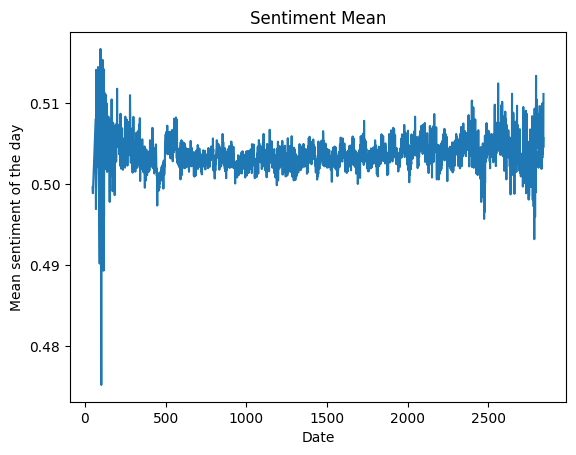

In [75]:
# The mean of the sentiment of the news articles in a given day
plt.plot(snp['sentiment_mean'])
plt.title("Sentiment Mean")
plt.ylabel("Mean sentiment of the day")
plt.xlabel("Date")
plt.show()

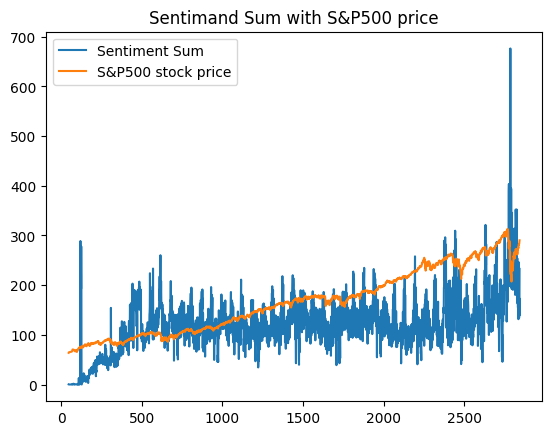

In [76]:
# The sum of all the sentiments of the news articles compaired to the close price in a given day
plt.plot(snp['sentiment_sum']/2, label="Sentiment Sum") # Divided by 2 to make the graphs easier to read
plt.plot(snp['Close'], label="S&P500 stock price")
plt.legend()
plt.title("Sentimand Sum with S&P500 price")
plt.show()

### Simple models sentiment mean

In [77]:
# Defining the training a testing data
X = snp.drop(snp[['Date','Change','label','sentiment_sum']], axis=1)
y = snp['label']

In [78]:
# Spliting the data in to train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
# Scaling the data
scaler_normal_models2 = MinMaxScaler(feature_range=(-1,1))
X_train_scaled = scaler_normal_models2.fit_transform(X_train)
X_test_scaled = scaler_normal_models2.transform(X_test)

In [80]:
# Using XGBRegressor
xgb = XGBRegressor(random_state =42)
xgb.fit(X_train_scaled, y_train)
y_test_pred = xgb.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)
print(f'mse: {mse}, rmse:{rmse}, r2: {r2}')

mse: 0.5718383878219767, rmse:0.7561999654998516, r2: -0.0967057041676036


In [81]:
# Using Random Forset
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=40,
                            min_samples_split=4,
                            max_samples=200,
                            random_state=42)
rf.fit(X_train_scaled, y_train)
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'train accuracy: {train_accuracy}')
print(f'test accuracy: {test_accuracy}')
print(f'delta: {train_accuracy-test_accuracy}')

# We got very poor results :(

train accuracy: 0.618421052631579
test accuracy: 0.5499092558983666
delta: 0.0685117967332124


In [82]:
# Useing KNN
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train_scaled, y_train)
y_train_pred = knn.predict(X_train_scaled)
y_test_pred = knn.predict(X_test_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'train accuracy: {train_accuracy}')
print(f'test accuracy: {test_accuracy}')
print(f'delta: {train_accuracy-test_accuracy}')

# We got very poor results :(

train accuracy: 0.5984573502722323
test accuracy: 0.5245009074410163
delta: 0.07395644283121605


In [83]:
# Using Decision Tree classifier
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'train accuracy: {train_accuracy}')
print(f'test accuracy: {test_accuracy}')
print(f'delta: {train_accuracy-test_accuracy}')

# We can see that using Decision Trees, the model is VERY overfitted

train accuracy: 1.0
test accuracy: 0.4573502722323049
delta: 0.5426497277676952


In [84]:
# Using LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'train accuracy: {train_accuracy}')
print(f'test accuracy: {test_accuracy}')
print(f'delta: {train_accuracy-test_accuracy}')

# We got very poor results :(

train accuracy: 0.5063520871143375
test accuracy: 0.5499092558983666
delta: -0.04355716878402904


### Simple models sentiment sum

In [85]:
# Defining the training a testing data
X = snp.drop(snp[['Date','Change','label','sentiment_mean']], axis=1)
y = snp['label']

In [86]:
# Spliting the data in to train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
# Scaling the data
scaler_normal_models_sum = MinMaxScaler(feature_range=(-1,1))
X_train_scaled = scaler_normal_models_sum.fit_transform(X_train)
X_test_scaled = scaler_normal_models_sum.transform(X_test)

In [88]:
# Using Random Forset
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=40,
                            min_samples_split=4,
                            max_samples=200,
                            random_state=42)
rf.fit(X_train_scaled, y_train)
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'train accuracy: {train_accuracy}')
print(f'test accuracy: {test_accuracy}')
print(f'delta: {train_accuracy-test_accuracy}')

train accuracy: 0.6120689655172413
test accuracy: 0.5716878402903811
delta: 0.040381125226860215


In [89]:
# Useing KNN
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train_scaled, y_train)
y_train_pred = knn.predict(X_train_scaled)
y_test_pred = knn.predict(X_test_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'train accuracy: {train_accuracy}')
print(f'test accuracy: {test_accuracy}')
print(f'delta: {train_accuracy-test_accuracy}')

train accuracy: 0.5916515426497277
test accuracy: 0.5317604355716878
delta: 0.05989110707803991


In [90]:
# Using Decision Tree classifier
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'train accuracy: {train_accuracy}')
print(f'test accuracy: {test_accuracy}')
print(f'delta: {train_accuracy-test_accuracy}')

train accuracy: 1.0
test accuracy: 0.426497277676951
delta: 0.573502722323049


In [91]:
# Using LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'train accuracy: {train_accuracy}')
print(f'test accuracy: {test_accuracy}')
print(f'delta: {train_accuracy-test_accuracy}')

train accuracy: 0.5090744101633394
test accuracy: 0.5480943738656987
delta: -0.03901996370235927


### Windows model sentiment mean

In [92]:
snp.set_index('Date', inplace=True)

In [93]:
snp.head(5)

,Close,High,Low,Open,Volume,Change,label,Close_scaled,sentiment_mean,sentiment_sum
Date,,,,,,,,,,
2009-04-27,63.948521,64.820144,63.725032,63.829328,289581600,3.754658,1.0,-0.896563,0.499606,0.999211
2009-04-29,65.103218,65.825843,64.291200,64.455089,311505700,3.538612,1.0,-0.887761,0.498884,0.498884
2009-05-22,66.317528,67.047604,66.064240,66.645318,166811900,4.283600,1.0,-0.878504,0.508033,0.508033
2009-05-27,66.801788,68.351335,66.697492,68.120395,246015800,2.964973,1.0,-0.874813,0.496923,1.490768
2009-05-28,67.732986,68.045874,66.377135,67.390299,289095000,2.689362,1.0,-0.867714,0.514097,1.542292


In [94]:
split_time = int(len(X)*0.8)
train = snp[:split_time]
test = snp[split_time:]

In [95]:
#הגדרת סט אימון וסט בדיקה  כך שיכללו רק את העמודות הבאות:
train = train [['Close', 'sentiment_mean']].copy()
test = test [['Close', 'sentiment_mean']].copy()

In [96]:
#סטנדרטיזציה
scaler_sentiment_mean = MinMaxScaler(feature_range=(-1,1))
scaler_close = MinMaxScaler(feature_range=(-1,1))

#train
train['Close'] = scaler_close.fit_transform(train[['Close']])
train['sentiment_mean'] = scaler_sentiment_mean.fit_transform(train[['sentiment_mean']])
#test
test['Close'] = scaler_close.fit_transform(test[['Close']])
test['sentiment_mean'] = scaler_sentiment_mean.fit_transform(test[['sentiment_mean']])

In [97]:
def windowed_dataset_multivariate(df, window_size, batch_size, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(df.values)  # מכניסים את כל העמודות
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1, 0]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


In [98]:
window_size = 365 #רצינו שנה 365 אבל אין לנו מספיק נתוני מבחן
batch_size = 16

train_dataset = windowed_dataset_multivariate(train, window_size, batch_size)
valid_dataset = windowed_dataset_multivariate(test, window_size, batch_size)

In [99]:
num_features = train.shape[1]

In [100]:
model = Sequential([
    Input(shape=(window_size, num_features)),
    Bidirectional(LSTM(40, return_sequences=True)),
    Bidirectional(LSTM(40)),
    Dense(1)
    ])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Reduce learning rate if validation loss stagnates
    factor=0.5,  # Reduce learning rate by half
    patience=5,  # Wait 2 epochs before reducing
    min_lr=1e-6,  # Minimum learning rate allowed
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='stock_price_prediction.keras',  # Save model to this file
    monitor='val_loss',  # Track validation loss
    save_best_only=True,  # Save only the best version of the model
    mode='min',  # "min" since we want to minimize the loss
    verbose=1  # Print a message when saving the model
)

early_stoping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='auto',
    restore_best_weights=True,
    start_from_epoch=10
)

model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

history_mean = model.fit(
    train_dataset,
    validation_data=(valid_dataset),
    epochs=100,
    batch_size=64,
    callbacks = [reduce_lr, checkpoint, early_stoping]
)


Epoch 1/100
    115/Unknown 9s 45ms/step - loss: 0.0526

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.08061, saving model to stock_price_prediction.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0523 - val_loss: 0.0806 - learning_rate: 0.0010
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0723
Epoch 2: val_loss improved from 0.08061 to 0.06566, saving model to stock_price_prediction.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0719 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0540
Epoch 3: val_loss improved from 0.06566 to 0.04396, saving model to stock_price_prediction.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0537 - val_loss: 0.0440 - learning_rate: 0.0010
Epoch 4/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0148
Epoch 4: val_loss did not improve from 0.04396
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0147 - val_loss: 0.0495 - learning_rate: 0.0010
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


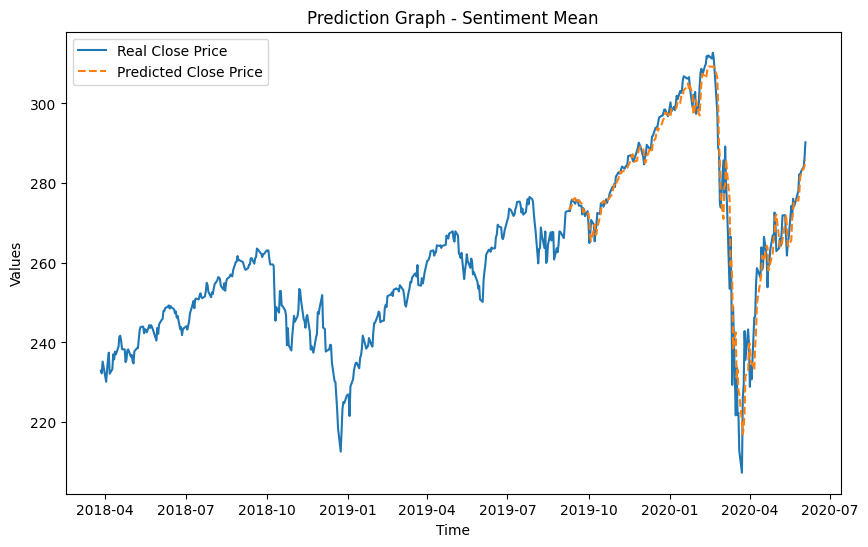

In [101]:
y_pred = model.predict(valid_dataset)

# מחזירים את הנתונים לסקאלה המקורית
y_pred = scaler_close.inverse_transform(y_pred.reshape(-1, 1))

test['Close'] = scaler_close.inverse_transform(test['Close'].values.reshape(-1, 1))

# הצגת כל שלושת המשתנים בגרף
plt.figure(figsize=(10,6))
plt.plot(test.index, test[['Close']], label="Real Close Price")
plt.plot(test.index[window_size:], y_pred[:,0], label="Predicted Close Price", linestyle="dashed")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Prediction Graph - Sentiment Mean")
plt.show()

### Windows model sentiment sum

In [111]:
split_time = int(len(X)*0.8)
train = snp[:split_time]
test = snp[split_time:]

In [112]:
#הגדרת סט אימון וסט בדיקה  כך שיכללו רק את העמודות הבאות:
train = train [['Close', 'sentiment_sum']].copy()
test = test [['Close', 'sentiment_sum']].copy()

In [113]:
#סטנדרטיזציה
scaler_sentiment_sum = MinMaxScaler(feature_range=(-1,1))
scaler_close_sum = MinMaxScaler(feature_range=(-1,1))

#train
train['Close'] = scaler_close_sum.fit_transform(train[['Close']])
train['sentiment_sum'] = scaler_sentiment_sum.fit_transform(train[['sentiment_sum']])
#test
test['Close'] = scaler_close_sum.fit_transform(test[['Close']])
test['sentiment_sum'] = scaler_sentiment_sum.fit_transform(test[['sentiment_sum']])

In [114]:
window_size = 365 #רצינו שנה 365 אבל אין לנו מספיק נתוני מבחן
batch_size = 16

train_dataset = windowed_dataset_multivariate(train, window_size, batch_size)
valid_dataset = windowed_dataset_multivariate(test, window_size, batch_size)

In [115]:
num_features = train.shape[1]

In [116]:
model = Sequential([
    Input(shape=(window_size, num_features)),
    Bidirectional(LSTM(40, return_sequences=True)),
    Bidirectional(LSTM(40)),
    Dense(1)
    ])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Reduce learning rate if validation loss stagnates
    factor=0.5,  # Reduce learning rate by half
    patience=5,  # Wait 2 epochs before reducing
    min_lr=1e-6,  # Minimum learning rate allowed
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='stock_price_prediction.keras',  # Save model to this file
    monitor='val_loss',  # Track validation loss
    save_best_only=True,  # Save only the best version of the model
    mode='min',  # "min" since we want to minimize the loss
    verbose=1  # Print a message when saving the model
)

early_stoping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='auto',
    restore_best_weights=True,
    start_from_epoch=10
)

model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

history_sum = model.fit(
    train_dataset,
    validation_data=(valid_dataset),
    epochs=100,
    batch_size=64,
    callbacks = [reduce_lr, checkpoint, early_stoping]
)


Epoch 1/100
    114/Unknown 8s 41ms/step - loss: 0.0575

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.24409, saving model to stock_price_prediction.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0569 - val_loss: 0.2441 - learning_rate: 0.0010
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0614
Epoch 2: val_loss improved from 0.24409 to 0.08463, saving model to stock_price_prediction.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0610 - val_loss: 0.0846 - learning_rate: 0.0010
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0044
Epoch 3: val_loss improved from 0.08463 to 0.04927, saving model to stock_price_prediction.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0044 - val_loss: 0.0493 - learning_rate: 0.0010
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0088
Epoch 4: val_loss did not improve from 0.04927
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0088 - val_loss: 0.0647 - learning_rate: 0.0010
Epoch 5/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - lo

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


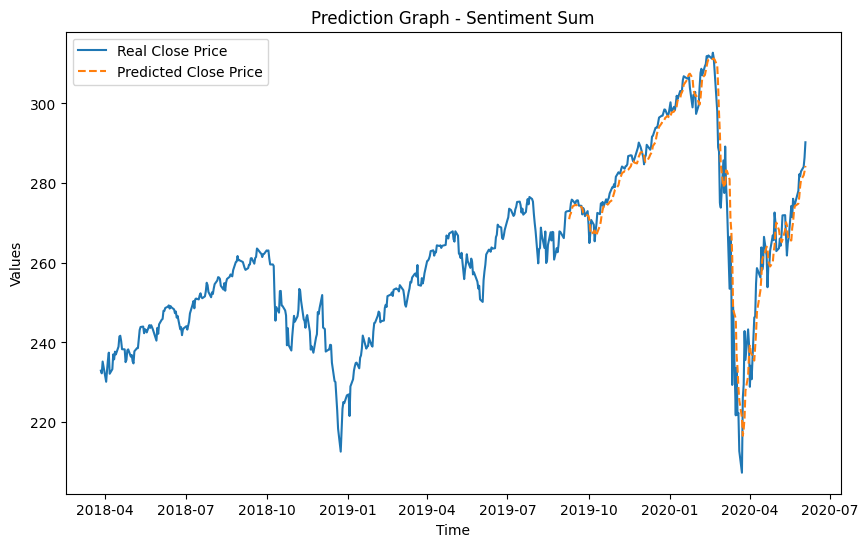

In [117]:
y_pred = model.predict(valid_dataset)

# מחזירים את הנתונים לסקאלה המקורית
y_pred = scaler_close_sum.inverse_transform(y_pred.reshape(-1, 1))

test['Close'] = scaler_close_sum.inverse_transform(test['Close'].values.reshape(-1, 1))

# הצגת כל שלושת המשתנים בגרף
plt.figure(figsize=(10,6))
plt.plot(test.index, test[['Close']], label="Real Close Price")
plt.plot(test.index[window_size:], y_pred[:,0], label="Predicted Close Price", linestyle="dashed")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Prediction Graph - Sentiment Sum")
plt.show()

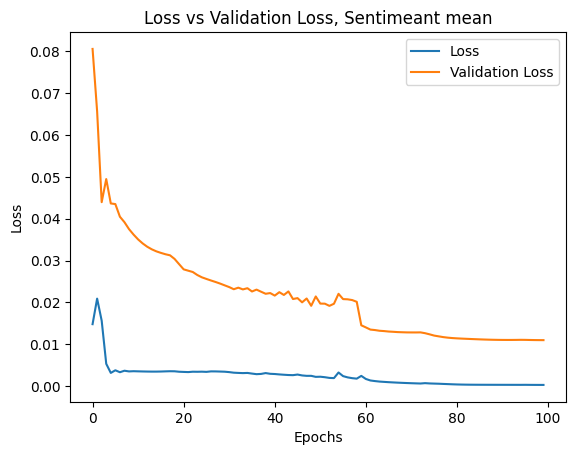

In [118]:
plt.plot(history_mean.history['loss'], label='Loss')
plt.plot(history_mean.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss, Sentimeant mean')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

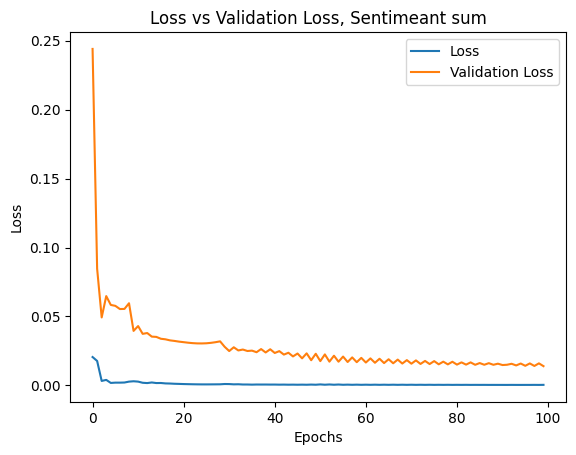

In [119]:
plt.plot(history_sum.history['loss'], label='Loss')
plt.plot(history_sum.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss, Sentimeant sum')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()